# Predict future return by Neural Network

# Implementation remarks:
* This setting Inspired by a famous kaggle repository about predicting the NY stock price
* Neural Networks based techniques are strong tools for machine learning, however, the hardest thing is tuning it to the right parameters
* In this implementation, I had run multiple times and selected the best features for all technique
    * Dropped features : Sales, close return, hi/lo
* These models are trained on Graphic Cards nVidia GTX 1050i 4G

* See more at : https://skymind.ai/wiki/lstm and https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru <br>
<br>

**NOTE** : please do not remove the output of this notebook, it took a long time to rerun all over again

In [1]:
import numpy as np
import pandas as pd
import pickle
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from numba import cuda

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


In [2]:
with open(r"full_df.pickle", "rb") as input_file:
    df = pickle.load(input_file)

In [3]:
df.head()

,ticker,open,high,low,close,volume,close_return,future_return,hi_lo,hi-lo,sales
date,,,,,,,,,,,
2015-01-05,AAA,50.11,50.11,50.09,50.11,35205,0.000000,0.000000,1.000399,0.02,1764122.550
2015-01-06,AAA,50.11,50.12,50.11,50.11,11138,0.000000,0.000200,1.000200,0.01,558125.180
2015-01-07,AAA,50.10,50.12,50.10,50.12,27378,0.000200,0.000000,1.000399,0.02,1371911.580
2015-01-08,AAA,50.13,50.13,50.11,50.12,20046,0.000000,0.000399,1.000399,0.02,1004805.750
2015-01-09,AAA,50.13,50.14,50.12,50.14,12745,0.000399,-0.000399,1.000399,0.02,638970.575


In [4]:
idx = 123
selected_stock = df.ticker.unique()[idx                           ]
selected_stock

'REA'

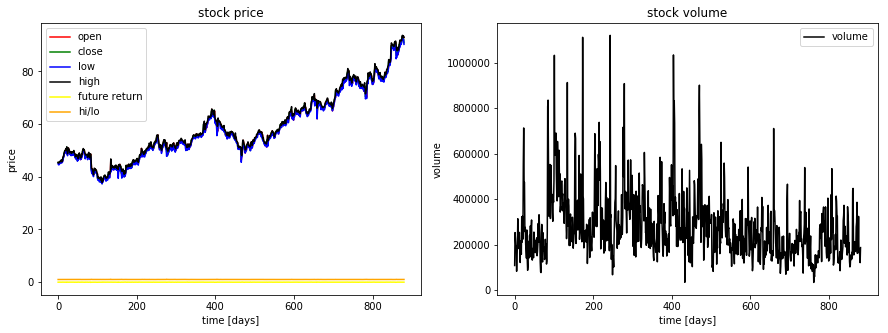

In [5]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.ticker == selected_stock].open.values, color='red', label='open')
plt.plot(df[df.ticker == selected_stock].close.values, color='green', label='close')
plt.plot(df[df.ticker == selected_stock].low.values, color='blue', label='low')
plt.plot(df[df.ticker == selected_stock].high.values, color='black', label='high')
plt.plot(df[df.ticker == selected_stock].future_return.values, color='yellow', label='future return')
plt.plot(df[df.ticker == selected_stock].hi_lo.values, color='orange', label='hi/lo')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.ticker == selected_stock].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

In [6]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    df['close_return'] = min_max_scaler.fit_transform(df['close_return'].values.reshape(-1,1))
    df['future_return'] = min_max_scaler.fit_transform(df['future_return'].values.reshape(-1,1))
    df['hi_lo'] = min_max_scaler.fit_transform(df['hi_lo'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.ticker == selected_stock].copy()
df_stock.drop(['ticker'],1,inplace=True)


cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
# df_stock_norm.drop(['volume'],1,inplace=True)
df_stock_norm.drop(['close_return'],1,inplace=True)
# df_stock_norm.drop(['future_return'],1,inplace=True)
df_stock_norm.drop(['hi_lo'],1,inplace=True)
df_stock_norm.drop(['sales'],1,inplace=True)


# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'high', 'low', 'close', 'volume', 'close_return', 'future_return', 'hi_lo', 'hi-lo', 'sales']
x_train.shape =  (689, 19, 7)
y_train.shape =  (689, 7)
x_valid.shape =  (86, 19, 7)
y_valid.shape =  (86, 7)
x_test.shape =  (86, 19, 7)
y_test.shape =  (86, 7)


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


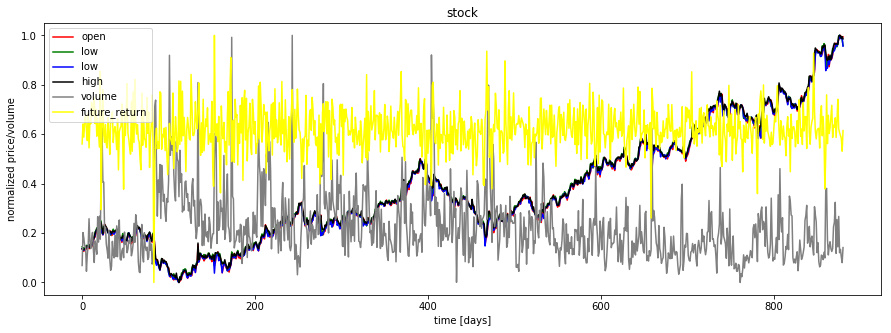

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.plot(df_stock_norm['future_return'].values, color='yellow', label='future_return')
# plt.plot(df_stock_norm['hi_lo'].values, color='purple', label='hi_lo')
# plt.plot(df_stock_norm['sales'].values, color='orange', label='sales')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [8]:
df_stock_norm.head()

,open,high,low,close,volume,future_return,hi-lo
date,,,,,,,
2015-01-05,0.135199,0.136355,0.137053,0.144086,0.068609,0.560768,0.58
2015-01-06,0.129603,0.130980,0.131094,0.136559,0.201802,0.641155,0.61
2015-01-07,0.125632,0.132951,0.129830,0.139964,0.178337,0.588222,0.79
2015-01-08,0.135379,0.137251,0.134706,0.136201,0.147278,0.658415,0.76
2015-01-09,0.131949,0.136714,0.138678,0.141935,0.146819,0.675242,0.51


* n_steps = seq_len-1 
* n_inputs = 7
* n_neurons = 300
* n_outputs = 7
* n_layers = 5
* learning_rate = 0.0001
* batch_size = 50
* n_epochs = 100 

## GRU cell
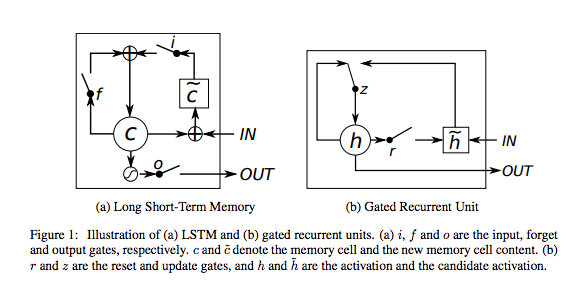


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
0.00 epochs: MSE train/valid = 0.343465/0.634845
4.93 epochs: MSE train/valid = 0.061867/0.092653
9.87 epochs: MSE train/valid = 0.052457/0.050267
14.80 epochs: MSE train/valid = 0.051578/0.048317
19.74 epochs: MSE train/valid = 0.051271/0.049371
24.67 epochs: MSE train/va

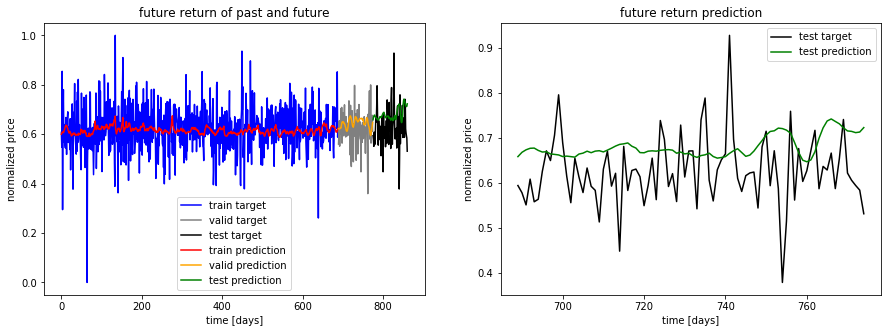

In [9]:


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

###################################### parameters################################
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

###############################################Select type of Neural Network###########################

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
         for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
########################################## plot and benchmark###################################

ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

###Release GPU memory###
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

Seems we are not there yet! It's seems to be overfitted where MSE for train/valid/test: 0.00882/0.01161/0.01848
<br>
<br>
Let's try another NN setting - LSTM

## LSTM Cell with peephole connections

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.352814/0.650674
4.93 epochs: MSE train/valid = 0.064649/0.097067
9.87 epochs: MSE train/valid = 0.059802/0.083942
14.80 epochs: MSE train/valid = 0.057491/0.077906
19.74 epochs: MSE train/valid = 0.052001/0.054206
24.67 epochs: MSE train/valid = 0.051743/0.057595
29.61 epochs: MSE train/valid = 0.052130/0.057781
34.54 epochs: MSE train/valid = 0.051415/0.053807
39.48 epochs: MSE train/valid = 0.051425/0.049767
44.41 epochs: MSE train/valid = 0.051323/0.051621
49.35 epochs: MSE train/valid = 0.051045/0.050163
54.28 epochs: MSE train/valid = 0.051518/0.054038
59.22 epochs: MSE train/valid = 0.051772/0.053337
64.15 epochs: MSE train/valid = 0.050983/0.049775
69.09 epochs: MSE train/valid = 0.050732/0.051368
74.02 epochs: MSE train/valid = 0.050767/0.049207
78.96 epochs: MSE train/valid = 0.050588/0.054373
83.89 epochs: MSE train/

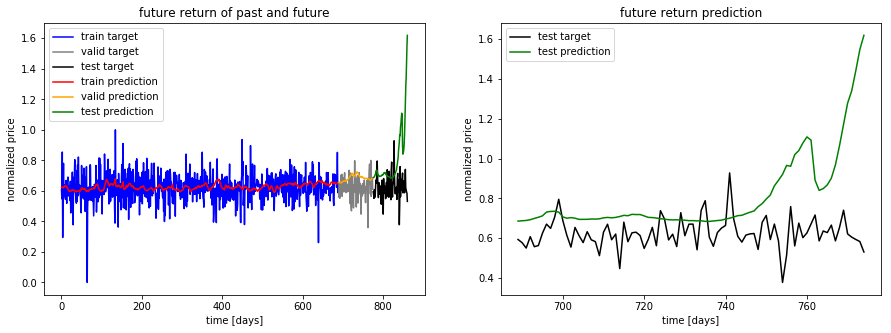

In [10]:


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

###################################### parameters################################
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


#### ##########################################Select type of Neural Network###########################

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
#### plot and benchmark###


ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

MSE for train/valid/test: 0.00938/0.00756/0.00652 <br>
<br>
This one even worse than the previous one, it's over fitting ,Try the normal LSTM

## LSTM cell
the figure below illustrates what happen in a LSTM cell
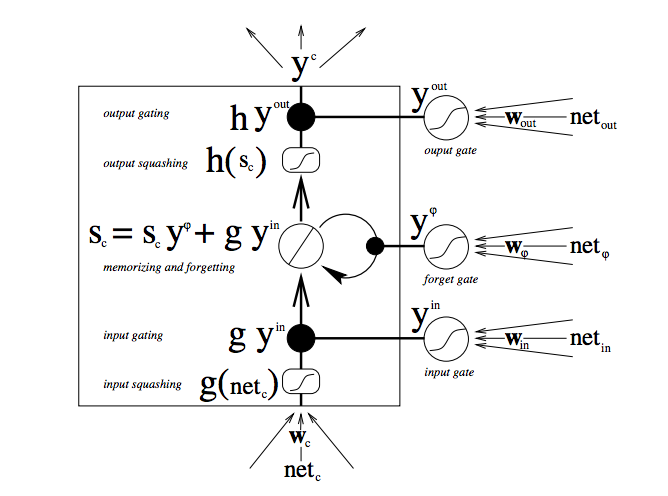

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.345094/0.639078
4.93 epochs: MSE train/valid = 0.058646/0.088946
9.87 epochs: MSE train/valid = 0.052343/0.046489
14.80 epochs: MSE train/valid = 0.051993/0.050418
19.74 epochs: MSE train/valid = 0.051869/0.047646
24.67 epochs: MSE train/valid = 0.051601/0.051641
29.61 epochs: MSE train/valid = 0.051432/0.048577
34.54 epochs: MSE train/valid = 0.051498/0.047401
39.48 epochs: MSE train/valid = 0.052232/0.053953
44.41 epochs: MSE train/valid = 0.052060/0.046330
49.35 epochs: MSE train/valid = 0.051177/0.049117
54.28 epochs: MSE train/valid = 0.051239/0.052527
59.22 epochs: MSE train/valid = 0.051135/0.050615
64.15 epochs: MSE train/valid = 0.051161/0.047718
69.09 epochs: MSE train/valid = 0.051126/0.049760
74.02 epochs: MSE train/valid = 0.050764/0.048058
78.96 epochs: MSE train/valid = 0.051669/0.048141
83.89 epochs: MSE train/

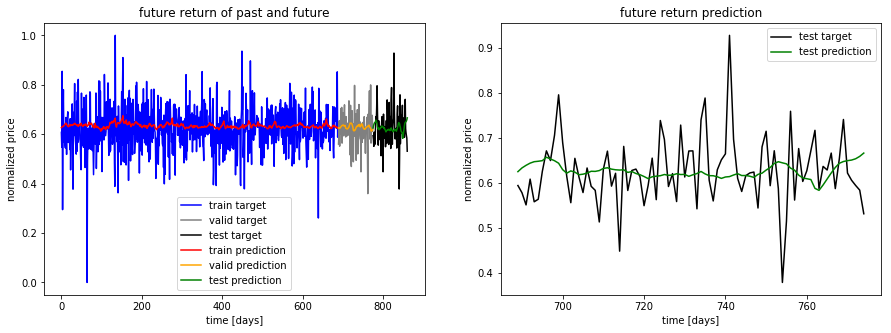

In [11]:

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

###################################### parameters################################
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


#### ##########################################Select type of Neural Network###########################
# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]

# use LSTM Cell with peephole connections
# layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
#################################################### plot and benchmark#############################


ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

MSE for train/valid/test: 0.00863/0.00574/0.00787<br>
<br>

LSTM seems fine, it's not over fitting but we are not there yet (see the plot)

## RNN cell
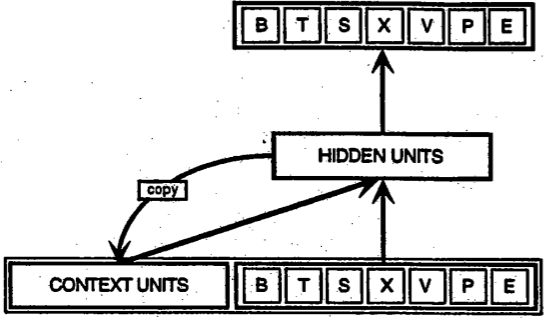

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.106172/0.221629
4.93 epochs: MSE train/valid = 0.048540/0.055344
9.87 epochs: MSE train/valid = 0.044875/0.052862
14.80 epochs: MSE train/valid = 0.048335/0.057670
19.74 epochs: MSE train/valid = 0.041893/0.052557
24.67 epochs: MSE train/valid = 0.039954/0.055334
29.61 epochs: MSE train/valid = 0.041485/0.060982
34.54 epochs: MSE train/valid = 0.038525/0.053674
39.48 epochs: MSE train/valid = 0.035191/0.058458
44.41 epochs: MSE train/valid = 0.035379/0.061481
49.35 epochs: MSE train/valid = 0.032386/0.062400
54.28 epochs: MSE train/valid = 0.033473/0.060191
59.22 epochs: MSE train/valid = 0.029668/0.063505
64.15 epochs: MSE train/valid = 0.024518/0.068224
69.09 epochs: MSE train/valid = 0.022507/0.067217
74.02 epochs: MSE train/valid = 0.020975/0.067451
78.96 epochs: MSE train/valid = 0.016347/0.073074
83.89 epochs: MSE t

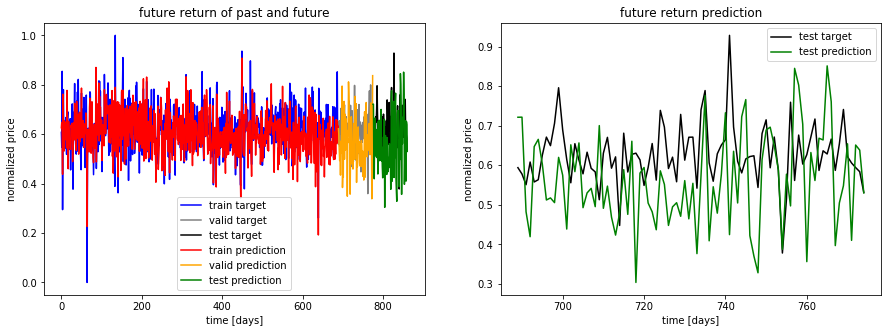

In [12]:
# Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


#### ##########################################Select type of Neural Network###########################
# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
# layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
# layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]




multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
############################################# plot and benchmark###############################


ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

###Release GPU memory###
from numba import cuda
cuda.select_device(0)
cuda.close()

## Winner : RNN

MSE for train/valid/test: 0.00664/0.01470/0.01969